## GAN Tutorial


https://github.com/eriklindernoren/PyTorch-GAN

위 Github의 코드에 기반한 튜토리얼 입니다. 위 Github에 Pytorch, Keras 기반의 다양한 모델들이 구현되어 있으니 활용해보시면 좋을 것 같습니다!

Initialize

In [2]:
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import easydict

os.makedirs("images", exist_ok=True)
opt = easydict.EasyDict({
        "batch_size": 64,
        "n_epochs": 200,
        "lr": 0.0002,
        "b1": 0.5, 
        "b2": 0.999, 
        "n_cpu": 8, 
        "latent_dim": 100, 
        "img_size": 28, 
        "channels": 1, 
        "sample_interval": 400, 
})

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

Generator and Discriminator Class

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [4]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



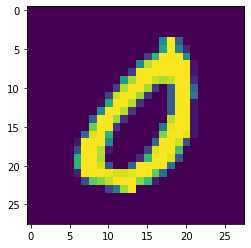

In [10]:
from matplotlib import pyplot as plt
for imgs, _ in dataloader:
  plt.imshow(imgs[0].reshape((28,28)))
  break

Training

In [11]:
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 35/200] [Batch 635/938] [D loss: 0.179942] [G loss: 2.653835]
[Epoch 35/200] [Batch 636/938] [D loss: 0.144467] [G loss: 2.210647]
[Epoch 35/200] [Batch 637/938] [D loss: 0.253255] [G loss: 3.547445]
[Epoch 35/200] [Batch 638/938] [D loss: 0.115513] [G loss: 2.584911]
[Epoch 35/200] [Batch 639/938] [D loss: 0.155802] [G loss: 2.319173]
[Epoch 35/200] [Batch 640/938] [D loss: 0.293195] [G loss: 3.501932]
[Epoch 35/200] [Batch 641/938] [D loss: 0.190361] [G loss: 1.625590]
[Epoch 35/200] [Batch 642/938] [D loss: 0.231511] [G loss: 4.696664]
[Epoch 35/200] [Batch 643/938] [D loss: 0.174578] [G loss: 3.659929]
[Epoch 35/200] [Batch 644/938] [D loss: 0.281867] [G loss: 1.152794]
[Epoch 35/200] [Batch 645/938] [D loss: 0.282714] [G loss: 6.284404]
[Epoch 35/200] [Batch 646/938] [D loss: 0.171976] [G loss: 4.973003]
[Epoch 35/200] [Batch 647/938] [D loss: 0.204470] [G loss: 1.582724]
[Epoch 35/200] [Batch 648/938] [D loss: 0.133827] [G loss: 4.010605

TypeError: ignored

In [ ]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
gen_imgs = generator(z)

plt.imshow(gen_imgs[0])

## MIDI GAN Tutorial

In [16]:
!git clone https://github.com/slslslrhfem/MIDIgentutorial

Cloning into 'MIDIgentutorial'...
remote: Enumerating objects: 756, done.
remote: Counting objects: 100% (756/756), done.
remote: Compressing objects: 100% (553/553), done.
remote: Total 756 (delta 202), reused 752 (delta 201), pack-reused 0
Receiving objects: 100% (756/756), 851.88 KiB | 4.92 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [12]:
!pip install mido
!pip install h5py==2.10.0 --force-reinstall
!pip install pretty_midi
!pip install tensorflow==1.15.0
!pip install keras==2.3.1
!pip install midiutil
!pip install easydict

     |████████████████████████████████| 51 kB 2.9 MB/s 
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 15.7 MB 55.7 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 require

     |████████████████████████████████| 5.6 MB 3.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=995bd73c21179a5fe04add392f438f2d935dfe3efea0975c7457f655f0cac975
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
     |████████████████████████████████| 503 kB 72.4 MB/s 
     |████████████████████████████████| 3.8 MB 65.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7051a92952fd45b024f9934f9bd598b683de4ed4d4a2ea5790dc9d0dc35fe7a4
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-esti

In [13]:
from matplotlib import pyplot as plt
import os
import pandas
from midiutil.MidiFile import MIDIFile
import copy
import pretty_midi
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
import mido
from tqdm import tqdm
import scipy as sp
from sklearn.cluster import KMeans
import keras
import os
import json
import pandas
import tensorflow as tf
import numpy as np
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras.models import Sequential
import pickle
import pretty_midi
import mido
from tqdm import tqdm
import pickle
import copy

Using TensorFlow backend.


In [19]:
def get_meta(filename):
  with open('MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/descriptor/'+filename) as json_file:
    meta_data = json.load(json_file)
  return meta_data

In [17]:

csvfilenames=os.listdir('MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/prime_csv')
jsonfilenames=os.listdir('MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/descriptor')
midifilenames=os.listdir('MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/prime_midi')

midifilenames=sorted(midifilenames)
csvfilenames=sorted(csvfilenames)
jsonfilenames=sorted(jsonfilenames)



In [20]:
import pretty_midi
import mido
from tqdm import tqdm
midilist=[]
csvlist=[]
jsonlist=[]
prettymidilist=[]
for filenames in tqdm(midifilenames,position=0):
  midi_path='MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/prime_midi/'+filenames
  mid = mido.MidiFile(midi_path, clip=True)
  midilist.append(mid)
  prettymid=pretty_midi.PrettyMIDI(midi_path)
  prettymidilist.append(prettymid)

for filenames in tqdm(csvfilenames,position=0):
  csv_path='MIDIgentutorial/PPDD-Sep2018_sym_mono_small/PPDD-Sep2018_sym_mono_small/prime_csv/'+filenames
  csv = pandas.read_csv(csv_path)
  csvlist.append(csv)
for filenames in tqdm(jsonfilenames,position=0):
  jsonlist.append(get_meta(filenames))

#midifilenames와 list들의 순서는 같다고 생각하고 코드 작성

100%|██████████| 100/100 [00:00<00:00, 18372.70it/s]


아래의 코드는 csv기반의 Processing을 진행한다. 
MIDI 기반의 Processing은 다음 블록에 작성되어 있으며, 둘 중 하나만 굴리면 된다.

In [21]:
#이게 이제 input을 midi로 받는 코드.

bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
chord_list=[]
for i,songs in enumerate(prettymidilist):#곡마다.
  if('timeSignature' not in jsonlist[i]):
    jsonlist[i]['timeSignature']=[4,4]
  if(jsonlist[i]['timeSignature'] !=[4,4]):#!=[4,4]로 써서 4,4만고려가능
    pass
  else:
    for instrument in songs.instruments: #2. 어차피 instrument하나
      csvarray=[]
      for note in instrument.notes: #3
        row=[note.start*2, note.pitch, note.pitch, (note.end - note.start)*2, 0] #*2를 해줘야 제대로 하나의 bar가 하나의 단위가 된다.
        csvarray.append(row)
    csvarray=np.array(csvarray)
    one_bar_number=jsonlist[i]['timeSignature'][0]
    chord=jsonlist[i]['keyEstimate'][-5:]
    bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
    bar_info_list=[]
    for i in range(int(bar_number)):
      starting_bar_time=csvarray[0][0]+i*one_bar_number
      bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])
    bar_list.append(bar_info_list)# bar info list가 bar마다 csv내용들 담겨져 있는거다.
    one_bar_number_list.append(one_bar_number)
    starting_number_list.append(csvarray[0][0])
    chord_list.append(chord)

In [22]:
print(bar_list[0][0])#1번째 곡의 1번째 bar.
print(jsonlist[0])

[[ 0.         33.         33.          0.83333333  0.        ]
 [ 1.         37.         37.          0.5         0.        ]
 [ 1.5        38.         38.          0.33333333  0.        ]
 [ 2.         40.         40.          0.83333333  0.        ]
 [ 3.         33.         33.          0.75        0.        ]]
{'id': '00b7561d-c09b-41f2-bf21-537603fbe758', 'idLakh': 'ac0c789d9798acc2cda1c90c28bddb3d', 'bpm': 135, 'timeSignature': [4, 4], 'keyEstimate': 'A major'}


In [23]:
def nearest_time(time,minimum_size):
  #혹시나 값이 조금 벗어나는 엇박 음을 가까운 최소단위로 Shifting 하기 위한 함수
  num_to_multiply=time/minimum_size
  num_to_multiply=int(num_to_multiply)
  left_time=num_to_multiply*minimum_size
  right_time=left_time+minimum_size
  if (time-left_time>=right_time-time):
    return right_time
  return left_time

def bar_to_matrix3(bar,one_bar_number,starting_number,i):
  # 주어진 Bar를 24*24의 Pitch matrix(Piano-Roll)로 바꾸는 함수. 
  init=np.zeros((24,24))
  minimum_size=one_bar_number/24
  zero_time=starting_number+one_bar_number*i
  min_height=500
  for lists in bar:
    if min_height>lists[1]:
      min_height=lists[1]    
  for j,lists in enumerate(bar):
    #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    length=int(round(lists[3]/minimum_size))
    if (length>3):
      length=length-1#여러번 두두두 치는 음을 구별하기 위함
    if (point+length>23):
      length=23-point # 한 음이 2Bar에 걸쳐있는 경우 Bar 뒤쪽의 음을 무시한다.
    height=lists[1]-min_height
    while(height>23):
      height=height-12
    init[23-int(height)][point:point+length]+=1
  return init

In [24]:
bar_matrix_list3=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_matrix_list3):
  for j,bar in enumerate(songs):
    matrix3=bar_to_matrix3(bar,one_bar_number_list[i],starting_number_list[i],j)
    bar_matrix_list3[i][j]=matrix3

In [25]:
def bar_to_contour(bar,one_bar_number,starting_number,j):
  contour=[]
  pitch_change_list=[]
  duration_list=[]
  real_pitch_list=[]
  real_time_list=[]
  real_duration_list=[]
  now_pitch=1000
  first_time=starting_number+one_bar_number*j
  a=0
  for lists in bar:
    if(a!=0): 
      real_time_list.append(lists[0]-now_rhythm)
    now_rhythm=lists[0]
    a+=1
    if (first_time*1.001<lists[0]):#smoothing for case like first time=5.00001, lists[0]=5.0000..
      resting_time=lists[0]-first_time
      duration_list.append(resting_time)
      first_time=lists[0]
      pitch_change_list.append('Rest')
    if (now_pitch==1000):
      pitch_change_list.append('Starting_Point')
      real_pitch_list.append('Starting_Point')
      real_duration_list.append(lists[3])
      duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      a+=1
    else:
      pitch_change=lists[1]-now_pitch
      pitch_change_list.append(str(pitch_change))#나중에 int로 바꿔쓸 것. 자료형 터지는거 때문에 우선 스트링.
      duration_list.append(lists[3])
      real_duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      real_pitch_list.append(str(pitch_change))
  if (first_time*1.001<starting_number+one_bar_number*(j+1)):
    pitch_change_list.append('Rest')#마지막 Rest
    duration_list.append(starting_number+one_bar_number*(j+1)-first_time)
  if(len(bar)!=0):
    real_time_list.append(starting_number+one_bar_number*(j+1)-now_rhythm)
  contour.append(pitch_change_list)
  contour.append(duration_list)
  contour.append(real_pitch_list)
  contour.append(real_time_list)
  contour.append(real_duration_list)
  #something
  return contour



Plot에서 중요한것은 Y-Axis의 0~112의 숫자가 Note의 반대 성향을 가진다는 것이다.(숫자가 커질수록 Note의 높이가 낮아진다.) 이는 PianoRoll을 이미지 처럼 사용하는 과정에서, 직관적인 학습이 가능하도록 이와 같이 구현한 것이다.

In [26]:
bar_contour_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    contour=bar_to_contour(bar,one_bar_number_list[i],starting_number_list[i],j)
    bar_contour_list[i][j]=contour


In [27]:
print(bar_contour_list[0][0])


[['Starting_Point', 'Rest', '4.0', '1.0', 'Rest', '2.0', 'Rest', '-7.0', 'Rest'], [0.8333333333333333, 0.16666666666666674, 0.5, 0.33333333333333326, 0.16666666666666674, 0.833333333333333, 0.16666666666666696, 0.75, 0.25], ['Starting_Point', '4.0', '1.0', '2.0', '-7.0'], [1.0, 0.5, 0.5, 1.0, 1.0], [0.8333333333333333, 0.5, 0.33333333333333326, 0.833333333333333, 0.75]]


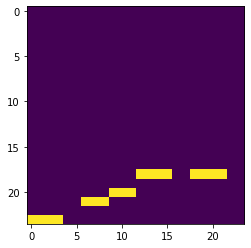

In [28]:
plt.imshow(np.array(bar_matrix_list3[30][1]),cmap='viridis')

###MIDI Generation with GAN

Code by eriklindernoren,
https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

이거는 Keras 기반의 모델도 사용해보겠습니다. (Torch 기반 모델이 이상하게 나온건 비밀)

In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
trainX=[]
for i,songs in enumerate(bar_matrix_list3):
  for matrix in songs:
    matrix=matrix.reshape(24,24)
    matrix=sp.ndimage.filters.gaussian_filter(matrix, [0.5,0.5], mode='constant') #bluring for well training.
    trainX.append(matrix)
trainX=np.array(trainX)

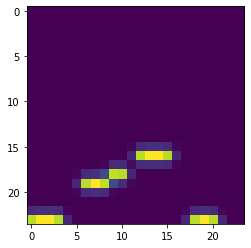

In [32]:
plt.imshow(trainX[0])

In [36]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 24
        self.img_cols = 24
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        with tf.device('/gpu:0'):
            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()

            noise = Input(shape=(self.latent_dim,))
            img = model(noise)

            return Model(noise, img)

    def build_discriminator(self):
        with tf.device('/gpu:0'):
            model = Sequential()

            model.add(Flatten(input_shape=self.img_shape))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(256))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()

            img = Input(shape=self.img_shape)
            validity = model(img)

            return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset

        X_train=trainX
        X_train = X_train / (0.5) - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if (epoch%500==0):
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()



In [37]:
gan = GAN()
gan.train(epochs=100000, batch_size=32, sample_interval=200)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               295424    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 427,009
Trainable params: 427,009
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.745474, acc.: 25.00%] [G loss: 0.600136]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.692658, acc.: 50.00%] [G loss: 0.634287]
1000 [D loss: 0.676321, acc.: 50.00%] [G loss: 0.672274]
1500 [D loss: 0.683616, acc.: 60.94%] [G loss: 0.702557]
2000 [D loss: 0.688648, acc.: 56.25%] [G loss: 0.736439]
2500 [D loss: 0.674399, acc.: 57.81%] [G loss: 0.743695]
3000 [D loss: 0.671131, acc.: 56.25%] [G loss: 0.726258]
3500 [D loss: 0.671829, acc.: 62.50%] [G loss: 0.774864]
4000 [D loss: 0.645427, acc.: 65.62%] [G loss: 0.728192]


KeyboardInterrupt: ignored

In [38]:
noise = np.random.normal(0, 1, (100, 100))
gen_imgs = gan.generator.predict(noise)

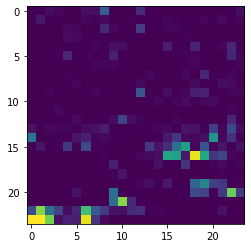

In [40]:
plt.imshow(gen_imgs[0].reshape((24,24)))

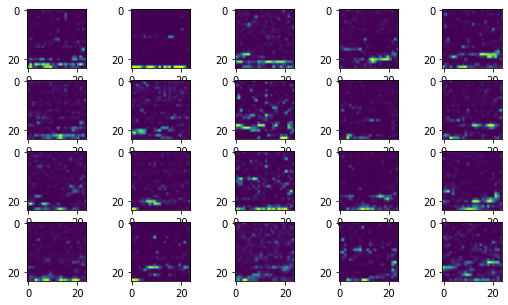

In [41]:
fig=plt.figure(figsize=(9, 5))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    img = gen_imgs[i].reshape((24,24))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

In [42]:
import cv2
H=gen_imgs[0]#n개의 24*24*1 형태

def matrix_cleaner(matrix):
  #matrix should be size of 24*24
  #make matrix's value of [0,1]  
  matrix=np.matrix(matrix)
  maximum_value=matrix.max()
  minimum_value=matrix.min()
  matrix=(matrix-minimum_value)/(maximum_value-minimum_value)
  flat=matrix.flatten()
  flat.sort()
  flat=flat.reshape((576,1))
  hundred_val=flat[-100]
  matrix_for_duration=np.where(matrix<0.1,0,matrix)
  matrix=np.where(matrix<hundred_val,0,matrix)
  matrix=np.where(matrix<1/3,0,matrix)
  
  return matrix,matrix_for_duration

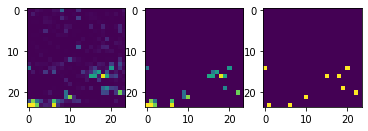

In [46]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp

#getting a list of images
paws = [matrix_cleaner(H)[0]]


def detect_peaks(image):


    neighborhood = generate_binary_structure(2,2)
    local_max = maximum_filter(image, footprint=neighborhood)==image
    background = (image==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background
    detected_peaks=np.where(detected_peaks==True,1,0)
    return detected_peaks


#applying the detection and plotting results
for i, paw in enumerate(paws):
    detected_peaks = detect_peaks(paw)
    pp.subplot(1,3,(2*i+1))
    pp.imshow(H.reshape((24,24)))
    pp.subplot(1,3,(2*i+2))
    pp.imshow(paw)
    pp.subplot(1,3,(2*i+3) )
    pp.imshow(detected_peaks)

pp.show()

[[14  0]
 [23  0]
 [23  6]
 [21 10]
 [16 15]
 [16 18]
 [19 18]
 [14 20]
 [20 22]] [1 1 2 2 2 4 1 1 2] [0.39312935 0.9973924  0.95733005 0.8241485  0.5958757  0.9678387
 0.3279473  0.52863497 0.77503735]


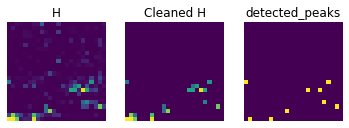

In [47]:
def left_shifting(matrix,detected_peak):
  #input은 detected_peak가 들어와야한다.
  dots=[]
  for j in range(len(detected_peak)):
    pos=[]
    for i in range(len(detected_peak[0])):#for 문의 순서를 이렇게 지정해야 Handle이 가능하다.
      a=0
      if(detected_peak[i][j]==1):
        if(j%2!=0 and j%3!=0):
          a=1
        if(len(pos)==0):
          pos=[i,j-a]
        else:
          if (matrix[0][pos[0]][pos[1]]<matrix[0][i][j-a]):
            pos=[i,j-a]
    if(len(pos)!=0):
      dots.append(pos)
  dots_with_length=[]
  starting_points=[]
  durations=[]
  velocities=[]
  for position in dots:
    velocities.append(matrix[1][position[0]][position[1]])
    length_val=0
    while True:
      if(length_val==0):
        starting_points.append([position[0],position[1]])
      else:
        if(position[1]+length_val>23):
          break
        if(detected_peak[position[0]][position[1]+length_val]!=0):
          break
      if(position[1]+length_val>23):
        break
      elif(matrix[1][position[0]][position[1]+length_val]!=0):
        dots_with_length.append([position[0],position[1]+length_val])
      else:
        break
      length_val+=1
    durations.append(length_val)
  result=np.zeros_like(matrix[0])
  for position in dots_with_length:
    result[position[0]][position[1]]=1
  return result,np.array(starting_points),np.array(durations),np.array(velocities)

paws = [matrix_cleaner(H)[0]]
detected_peaks = detect_peaks(paws[0])
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(H.reshape(24,24))
ax1.set_title('H')
ax1.axis("off")
 
ax3 = fig.add_subplot(1, 3, 2)
ax3.imshow(paws[0].reshape(24,24))
ax3.set_title('Cleaned H')
ax3.axis("off")

ax2 = fig.add_subplot(1, 3, 3)
ax2.imshow(detect_peaks(matrix_cleaner(H)[0]))
ax2.set_title('detected_peaks')
ax2.axis("off")

print(left_shifting(matrix_cleaner(H),detected_peaks)[1],left_shifting(matrix_cleaner(H),detected_peaks)[2],left_shifting(matrix_cleaner(H),detected_peaks)[3])

In [48]:
C_chord=[1,0,1,0,1,1,0,1,0,1,0,1]
chords=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
def chord_matching(shifted_matrix,chord,last_pitch,direction):
  #input은 left_shifting의 output을 그대로 넣고, chord(C,C#,D,D#....,B), 마지막 리듬의 pitch를 숫자로, 그리고 진행 방향을 direction(1,0)으로 받는다.
  #output은 MIDI기반의 decoding이 되도록 정보 기반으로, 그리고 last_pitch까지 넣어준다.
  #또한 출력 그림과 상관없이, 그냥 Note Pitch를 그냥 Matrix에 넣어준다.
  before_matrix=shifted_matrix[0]
  before_pitch=last_pitch
  if (last_pitch<40):
    direction=1
  if (last_pitch>80):
    direction=0
  if chord not in chords:
    now_chord='C'
  now_chord=chord
  chord_diff=chords.index(now_chord)
  now_chord_list=np.roll(C_chord,chord_diff)#[1,0,1,0,1...] 이런 set인데 여기에 맞추면 함수에 넣은 chord에 맞게 된다.
  #나중에 그냥 chord뿐만 아니라 화음의 종류까지 고민하게 된다면 이걸 잘 쓰면 된다.
  pitch_set=[]
  for pitchs in shifted_matrix[1]:
    pitch_set.append(23-pitchs[0])#위 그림 기준 7,17,9,7,3,5 이렇게 들감
  pitch_set=pitch_set-pitch_set[0]#이러면 0, 10, -1, 0 ,-4, -2, 이렇게 들간다. 상대적인 위치를 다루는게 쉽다.
  if (direction==1):
    possible_set=[]
    for i in range(12):
      possible_set.append(pitch_set+i+last_pitch)
  else:
    possible_set=[]
    for i in range(12):
      possible_set.append(pitch_set-i+last_pitch)
  possible_set_score=[]
  for sets in possible_set:
    score=0
    for pitchs in sets:
      score+=now_chord_list[pitchs%12]
    possible_set_score.append(score)
  final_set=possible_set[np.argmax(possible_set_score)]
  return_val=[]
  for i,sets in enumerate(final_set):
    if (before_pitch-sets<-12):
      sets=sets-12
    if (before_pitch-sets>12):
      sets=sets+12               #For prevent pitch change above 1 Octave.
    if(now_chord_list[sets%12]==1):
      final=[]
      if (shifted_matrix[2][i]!=0):
        final.append(sets)#pitch
        final.append(shifted_matrix[1][i][1])
        final.append(shifted_matrix[2][i])
        final.append(shifted_matrix[3][i])
        return_val.append(final)
    before_pitch=sets
  return return_val


In [49]:
shifted=left_shifting(matrix_cleaner(H),detect_peaks(matrix_cleaner(H)[0]))
print(chord_matching(shifted,'C',48,1))

[[50, 0, 1, 0.39312935], [41, 0, 1, 0.9973924], [41, 6, 2, 0.95733005], [43, 10, 2, 0.8241485], [48, 15, 2, 0.5958757], [48, 18, 4, 0.9678387], [45, 18, 1, 0.3279473], [50, 20, 1, 0.52863497]]


In [50]:
H=gen_imgs[0]
shifted=left_shifting(matrix_cleaner(H),detect_peaks(matrix_cleaner(H)[0]))
final_list=chord_matching(shifted,'C',48,1)

In [51]:
for i in final_list:
  print(i)

[50, 0, 1, 0.39312935]
[41, 0, 1, 0.9973924]
[41, 6, 2, 0.95733005]
[43, 10, 2, 0.8241485]
[48, 15, 2, 0.5958757]
[48, 18, 4, 0.9678387]
[45, 18, 1, 0.3279473]
[50, 20, 1, 0.52863497]


In [54]:
import midiutil
from midiutil.MidiFile import MIDIFile
os.mkdir("midis")
for i in range(10):
  for chord in chords:
    H=gen_imgs[i]
    shifted=left_shifting(matrix_cleaner(H),detect_peaks(matrix_cleaner(H)[0]))
    final_list=chord_matching(shifted,chord,48,1)
    # create your MIDI object
    mf = MIDIFile(1)     # only 1 track
    track = 0   # the only track

    time = 0    # start at the beginning
    mf.addTrackName(track, time, "Sample Track")
    mf.addTempo(track, time, 120)#2초에 1bar

    # add some notes
    channel = 0
    used_time=[]
    for j,notes in enumerate(final_list):
      pitch = notes[0]+12           # C4 (middle C) 48이 C4인 내구현에 비해 여기는 60이 C4이다.
      time = notes[1]/6             # start on beat 0
      duration = notes[2]/6         # 1 beat long
      volume= int(notes[3]*100)
      if (time not in used_time and duration!=0):
        mf.addNote(track, channel, pitch, time, duration, volume)
        used_time.append(time)
    with open("midis/"+str(i)+' '+chord+".mid", 'wb') as outf:
      mf.writeFile(outf)
      print(str(i)+' '+chord+"  generate done!")

0 C  generate done!
0 C#  generate done!
0 D  generate done!
0 D#  generate done!
0 E  generate done!
0 F  generate done!
0 F#  generate done!
0 G  generate done!
0 G#  generate done!
0 A  generate done!
0 A#  generate done!
0 B  generate done!
1 C  generate done!
1 C#  generate done!
1 D  generate done!
1 D#  generate done!
1 E  generate done!
1 F  generate done!
1 F#  generate done!
1 G  generate done!
1 G#  generate done!
1 A  generate done!
1 A#  generate done!
1 B  generate done!
2 C  generate done!
2 C#  generate done!
2 D  generate done!
2 D#  generate done!
2 E  generate done!
2 F  generate done!
2 F#  generate done!
2 G  generate done!
2 G#  generate done!
2 A  generate done!
2 A#  generate done!
2 B  generate done!
3 C  generate done!
3 C#  generate done!
3 D  generate done!
3 D#  generate done!
3 E  generate done!
3 F  generate done!
3 F#  generate done!
3 G  generate done!
3 G#  generate done!
3 A  generate done!
3 A#  generate done!
3 B  generate done!
4 C  generate done!


Bar가 1개 뿐이기도 하고, 아무것도 터치를 안한 그냥 GAN 모델이기 때문에 결과물이 썩 좋지는 않긴합니다. 다만 활용하기 나름이겠죠!

##Bonus) Code for MIDI Bar Clustering.

이런거도 되네.. 정도로만 보셔도 괜찮습니다. 디테일한 설명도 생략할 것 같습니다.

In [55]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
trainX=[]
clusterxinfo=[]
trainY=[]#info of Time Signature or chord

for i,songs in enumerate(bar_matrix_list3):
  for matrix in songs:
    matrix=matrix.reshape(24,24)
    matrix=sp.ndimage.filters.gaussian_filter(matrix, [0.5,0.5], mode='constant') #bluring for well training.
    trainX.append(matrix)
    trainY.append(chord_list[i])#Ise one_bar_number_list to use info of time signature
trainX=np.array(trainX)
trainY=np.array(trainY)
clusterX=trainX[:100000]
clusterY=trainY[:100000]
le.fit(clusterY)
clusterY=le.transform(clusterY)
clusterX=clusterX.reshape((clusterX.shape[0],-1))
n_clusters=len(np.unique(clusterY))

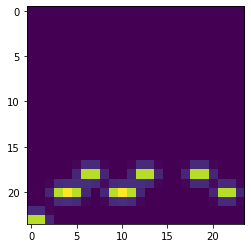

In [56]:
import matplotlib.pyplot as plt
plt.imshow(np.array(trainX[30]),cmap='viridis')

In [57]:
print(clusterX.shape)

(1505, 576)


In [58]:
from sklearn import metrics

kmeans = KMeans(n_clusters=5, n_init=10)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(clusterX)

metrics.accuracy_score(clusterY,y_pred_kmeans)

0.30697674418604654

In [67]:
dims = [clusterX.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256

In [68]:
from keras.layers import Dense, Input
from keras.models import Model
from keras.engine.topology import Layer, InputSpec
import keras.backend as K

def autoencoder(dims, act='relu', init='glorot_uniform'):

    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [69]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(clusterX, clusterX, batch_size=batch_size, epochs=100) #, callbacks=cb)
autoencoder.save_weights( 'ae_weights.h5')

Epoch 1/100
1505/1505 [==============================] - 0s 218us/step - loss: 0.0143
Epoch 2/100
1505/1505 [==============================] - 0s 19us/step - loss: 0.0139
Epoch 3/100
1505/1505 [==============================] - 0s 19us/step - loss: 0.0134
Epoch 4/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0129
Epoch 5/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0126
Epoch 6/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0124
Epoch 7/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0123
Epoch 8/100
1505/1505 [==============================] - 0s 20us/step - loss: 0.0122
Epoch 9/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0122
Epoch 10/100
1505/1505 [==============================] - 0s 19us/step - loss: 0.0122
Epoch 11/100
1505/1505 [==============================] - 0s 18us/step - loss: 0.0122
Epoch 12/100
1505/1505 [==============================] - 0s 1

In [70]:
print(clusterY)

[0 0 0 ... 0 0 0]


In [71]:
autoencoder.load_weights('ae_weights.h5')

In [72]:
class ClusteringLayer(Layer):

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):

        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def autoencoder(dims, act='relu', init='glorot_uniform'):

    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')



In [73]:
n_clusters=5
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(clusterX))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

loss = 0
index = 0
maxiter = 14000
update_interval = 140
index_array = np.arange(clusterX.shape[0])
tol = 0.001

In [76]:
def target_distribution(q):
  weight = q ** 2 / q.sum(0)
  return (weight.T / weight.sum(1)).T
for ite in range(14000):
    if ite % update_interval == 0:
        q = model.predict(clusterX, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if clusterY is not None:
            acc = np.round(metrics.accuracy_score(clusterY, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(clusterY, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(clusterY, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, clusterX.shape[0])]
    loss = model.train_on_batch(x=clusterX[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= clusterX.shape[0] else 0

model.save_weights( 'DEC_model_final.h5')
model.load_weights( 'DEC_model_final.h5')

Iter 0: acc = 0.25714, nmi = 0.00356, ari = 0.00343  ; loss= 0.10517
Iter 140: acc = 0.25714, nmi = 0.00356, ari = 0.00343  ; loss= 0.09659
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [77]:
q = model.predict(clusterX, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if clusterY is not None:
    acc = np.round(metrics.accuracy_score(clusterY, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(clusterY, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(clusterY, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.25714, nmi = 0.00356, ari = 0.00343  ; loss= 0.09659


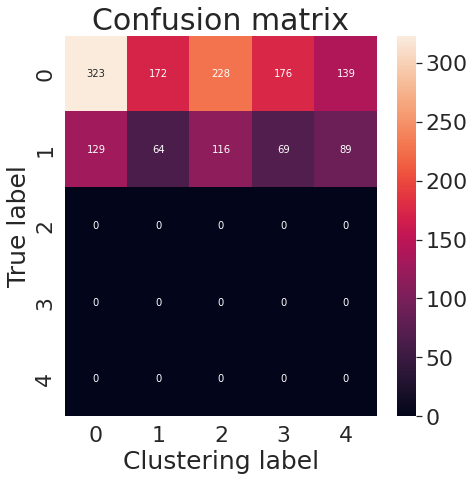

In [78]:
# chord scale과의 비교를 위한 코드. Label이 5개이므로 큰 의미는 없다. 사실 2개여도 큰 의미 없엇다.

sns.set(font_scale=2)
confusion_matrix = sklearn.metrics.confusion_matrix(clusterY, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()


In [79]:
cluster0=[]
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
for i,x in enumerate(y_pred):
  if x==0:
    cluster0.append(trainX[i])
  elif x==1:
    cluster1.append(trainX[i])
  elif x==2:
    cluster2.append(trainX[i])
  elif x==3:
    cluster3.append(trainX[i])
  elif x==4:
    cluster4.append(trainX[i])

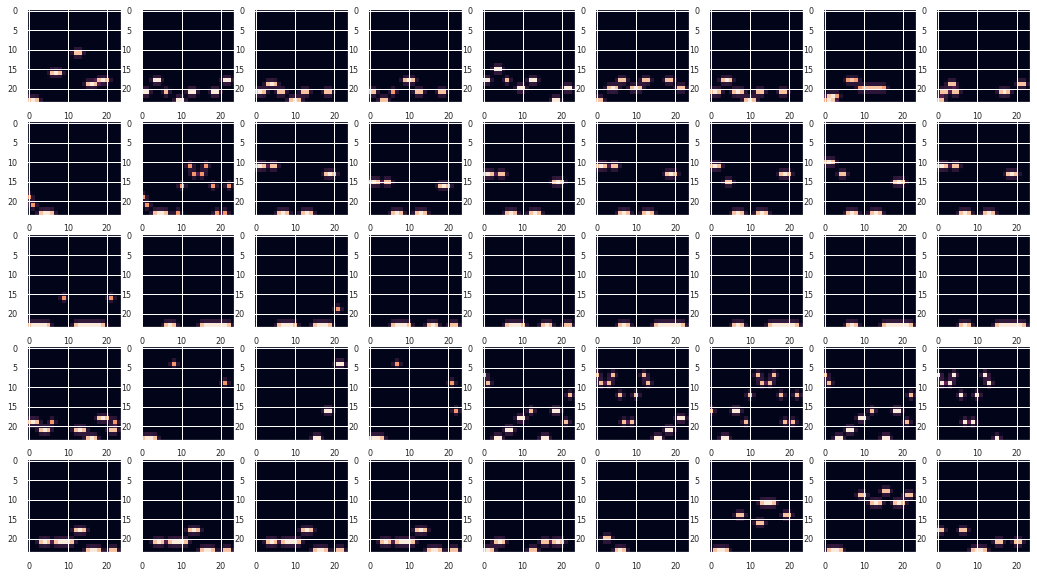

In [80]:
import numpy as np
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig=plt.figure(figsize=(18, 10))
columns = 9
rows = 5
for i in range(1, columns*rows +1):
    if i<10:
      img = cluster0[i]
    elif i<19:
      img = cluster1[i]
    elif i<28:
      img = cluster2[i]
    elif i<37:
      img = cluster3[i]
    elif i<46:
      img = cluster4[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()